# Средняя зарплата

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [50]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


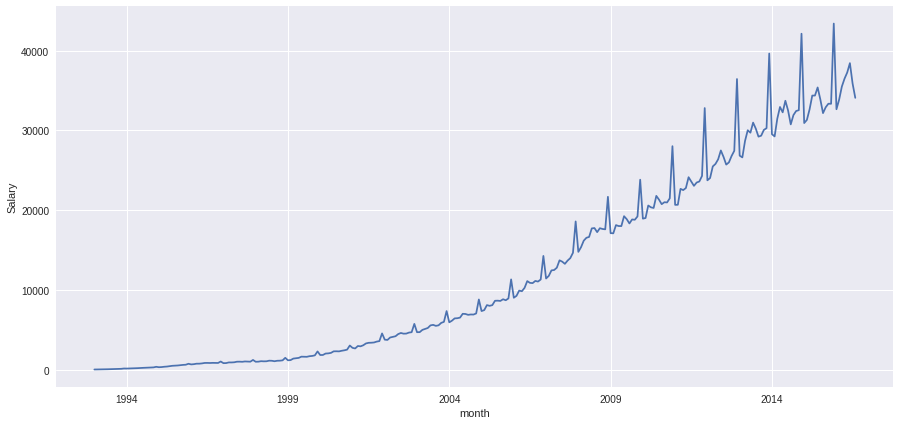

In [52]:
s = pd.read_csv('/WAG_C_M.csv', ';', index_col=['month'], 
                parse_dates=['month'], dayfirst=True).rename(index=str, columns={"WAG_C_M":"salary"})
s = s.set_index(pd.to_datetime(s.index))
plt.figure(figsize(15,7))
s.salary.plot()
plt.ylabel('Salary')
pylab.show()

Видим якро выраженный тренд, сезонность и различие дисперсий.

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

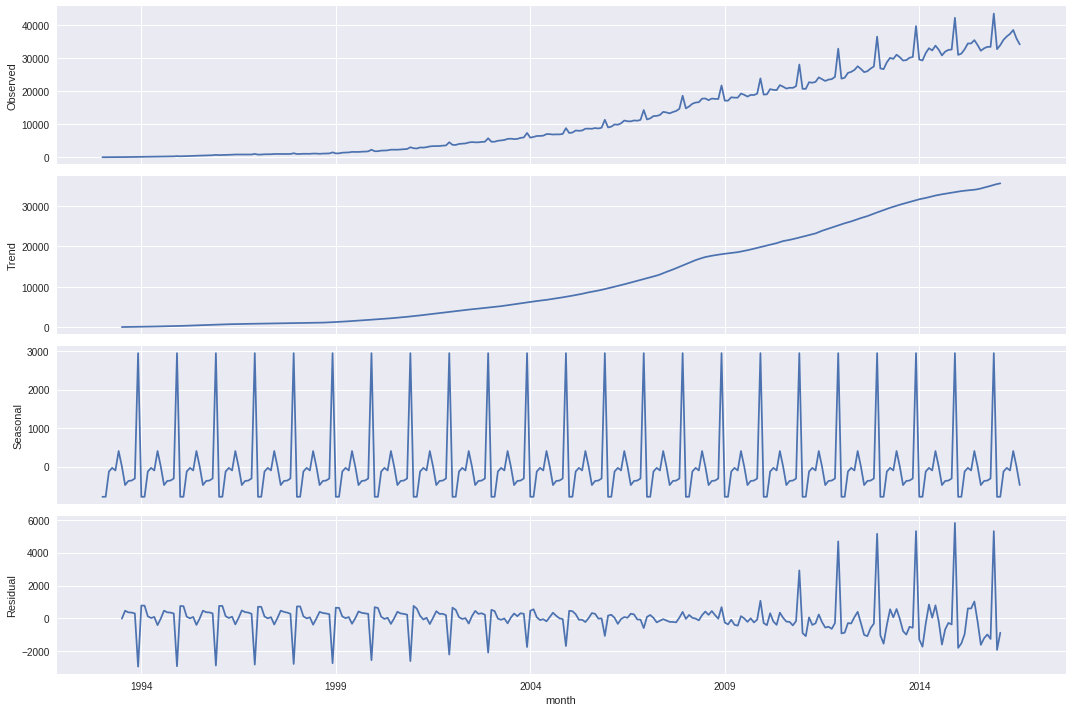

In [53]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(s.salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(s.salary)[1])

Сам внешний вид ряда (тренд+сезонность) + pvalue теста говорит о том, что ряд оень вероятно нестационарен.

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


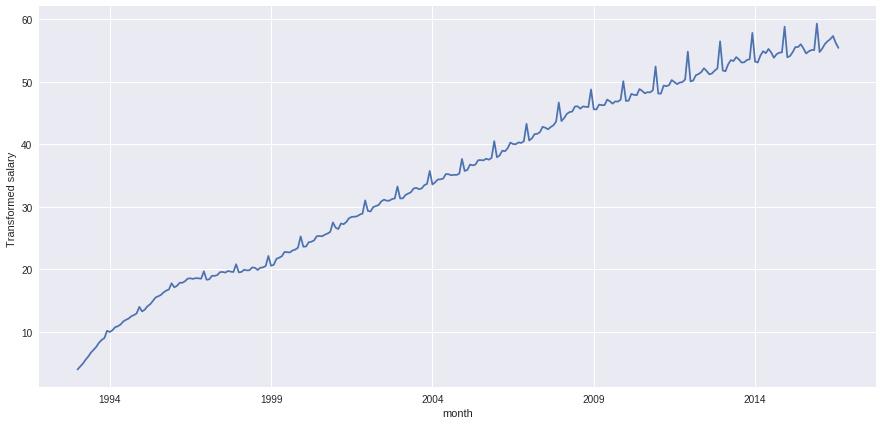

In [54]:
s['salary_box'], lmbda = stats.boxcox(s.salary)
plt.figure(figsize(15,7))
s.salary_box.plot()
plt.ylabel(u'Transformed salary ')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(s.salary_box)[1])

После преобразования все равно дисперсия не стабилизировалась + критерий не позволяет принять гипотезу о стационарности ряда с хорошим уровнем значимости.

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

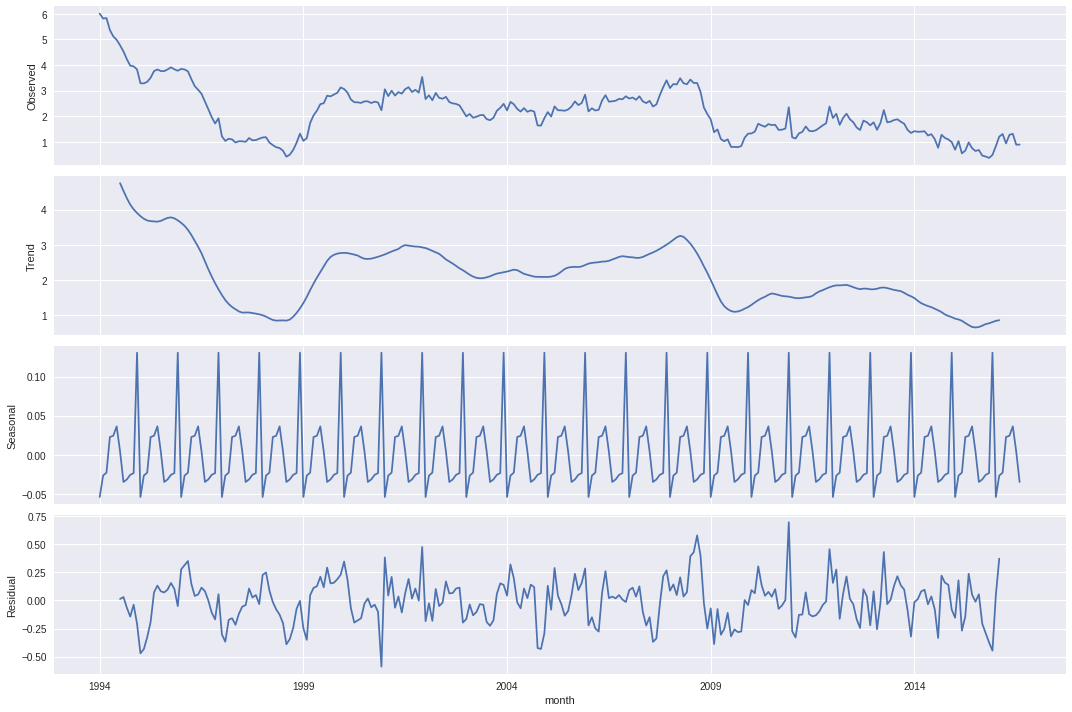

In [55]:
s['salary_box_diff'] = s.salary_box - s.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(s.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(s.salary_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

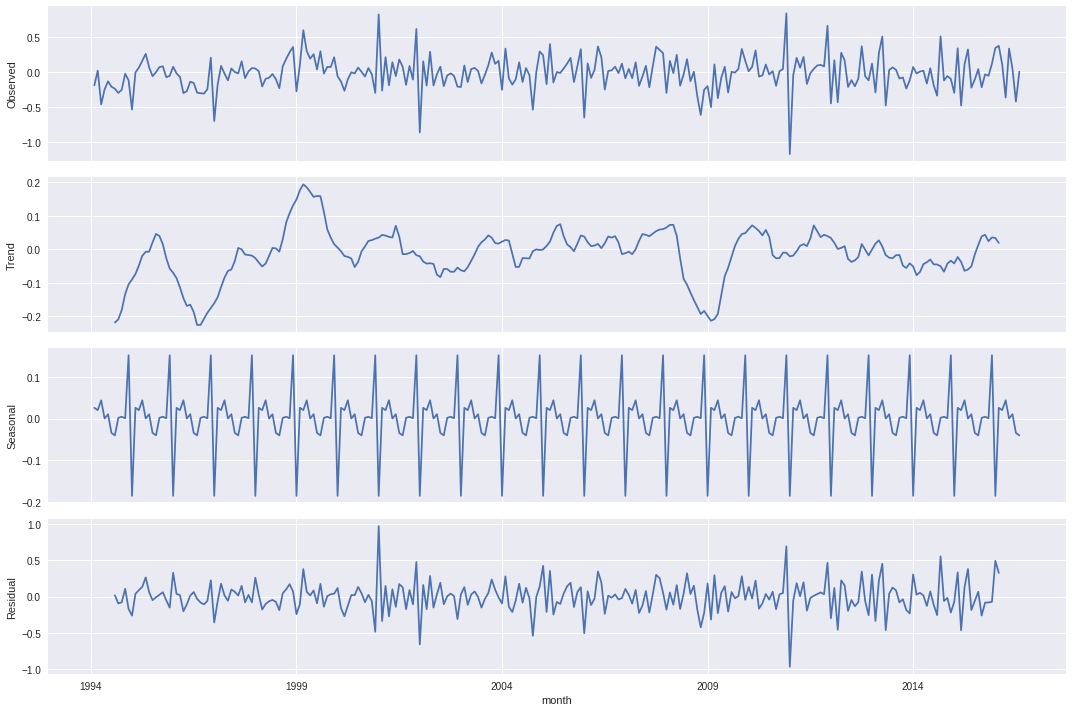

In [56]:
s['salary_box_diff2'] = s.salary_box_diff - s.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(s.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(s.salary_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

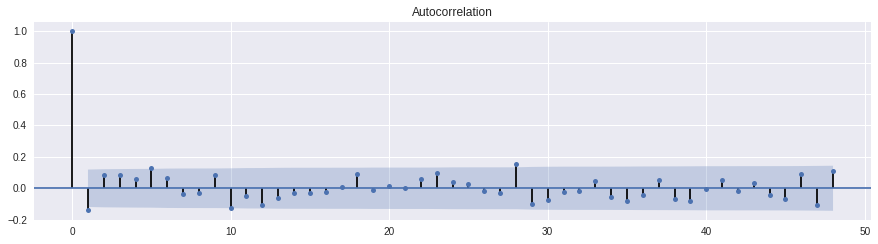

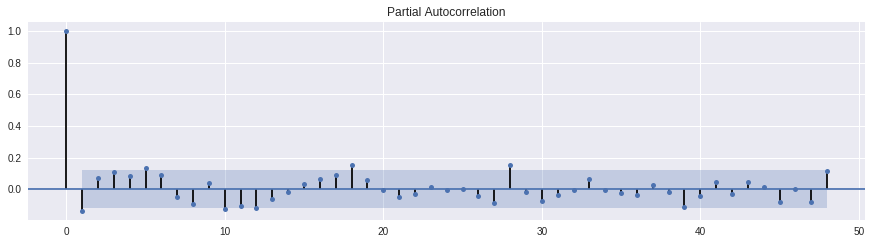

In [57]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(s.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(s.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Выбираем начальные приближения


По коррелограмме автокорреляций: 

Максимальный сезонный значимый лаг = 0 = 0*12 ; 0 = Q

Максимальный несезонный значимый лаг, меньший сезона (12) = 5 ; 5 = q


По коррелограмме частичных автокорреляций: 

Максимальный сезонный значимый лаг = 48 =  4*12 ; 4 = P

Максимальный несезонный значимый лаг, меньший сезона (12) = 10; 10 = p

Начальные приближения: Q=0, q=6, P=4, p=10

In [0]:
ps = range(1, 3)
d=1
qs = range(4, 6)
Ps = range(3, 4)
D=1
Qs = range(0, 1)

In [59]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

4

In [61]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(s.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 59.9 s, sys: 36.8 s, total: 1min 36s
Wall time: 48.7 s


In [63]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(144))

     parameters        aic
1  (1, 5, 3, 0) -12.987977
3  (2, 5, 3, 0) -11.055468
0  (1, 4, 3, 0)  -7.779812
2  (2, 4, 3, 0)  -5.815470


Лучшая модель:

In [64]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 5)x(3, 1, 0, 12)   Log Likelihood                  16.494
Date:                            Thu, 04 Apr 2019   AIC                            -12.988
Time:                                    15:40:33   BIC                             23.502
Sample:                                01-01-1993   HQIC                             1.642
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5725      0.153      3.745      0.000       0.273       0.872
ma.L1         -0.8049      0.156   

Её остатки:

Критерий Стьюдента: p=0.295481
Критерий Дики-Фуллера: p=0.000000


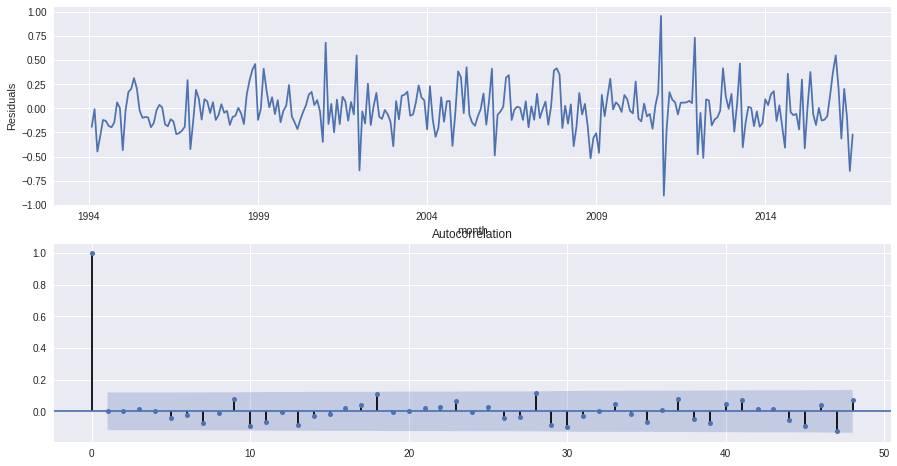

In [65]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

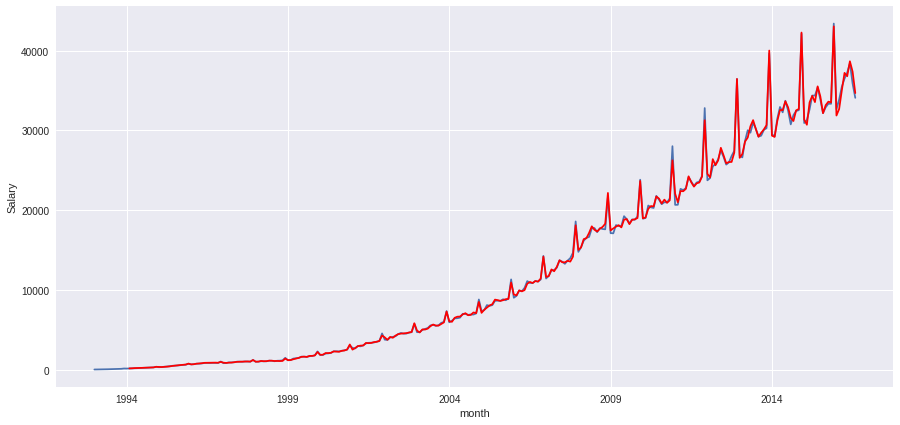

In [66]:
s['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
s.salary.plot()
s.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

### Прогноз

Добавим критерий, например R2

In [0]:
from sklearn.metrics import r2_score

разделим на 4 части: 0:71, 71:142, 142:213, 213:284. Учимся на предыдущей, предсказываем  следующую

In [68]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

4

In [0]:
ps = range(0, 5)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [70]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

50

In [0]:
s2 = s[['salary']]

In [72]:
model=sm.tsa.statespace.SARIMAX(s.salary_box[0:71], order=(1, 1, 5), seasonal_order=(3, 1, 0, 12)).fit(disp=-1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1042: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [0]:
warnings.filterwarnings('default')
def fit_model(df):
    best_aic = float("inf")
    warnings.filterwarnings('ignore')

    model=sm.tsa.statespace.SARIMAX(df, order=(1, 1, 5), seasonal_order=(3, 1, 0, 12)).fit(disp=-1)
    return model


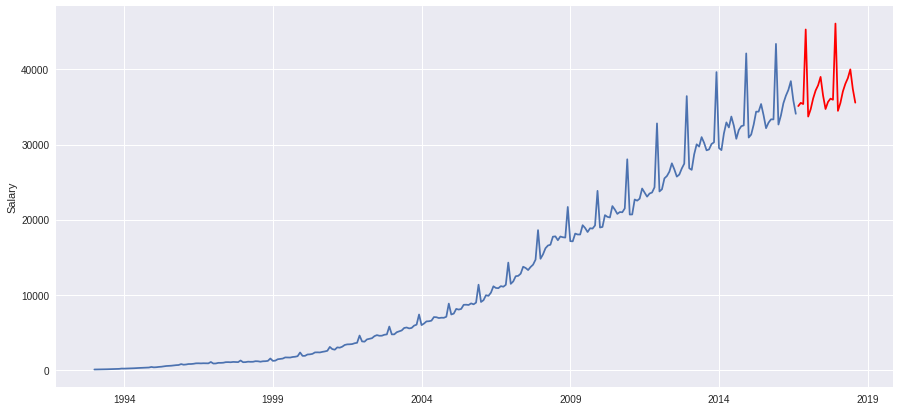

In [74]:
s2 = s[['salary']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= s2.columns)
s2 = pd.concat([s2, future])
s2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)

plt.figure(figsize(15,7))
s2.salary.plot()
s2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()

Прогноз учел характер временного ряда, кажется вполне адекватным

### Прогноз обычными средствами ML

Прогноз выполнится  с помощью регрессии, при это учтем окно около 5 значений назад

In [0]:
from sklearn.metrics import mean_absolute_error

In [0]:
s_ml = s.copy()

In [0]:
s_ml.reset_index(inplace=True)

In [0]:
for i in range(1, 11):
    s_ml['next' + str(i)] = s_ml['salary'].shift(-i)

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
regr = RandomForestRegressor()

In [0]:
s_fit = s_ml.iloc[:-11, :]

In [98]:
regr.fit(s_fit[['salary', 'next1', 'next2', 'next3', 'next4', 'next5', 'next6', 'next7', 'next8', 'next9']], s_fit['next10'])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
list_value = s['salary'].tolist()

In [0]:
for i in range(1, 20):
    n = regr.predict(np.array(list_value[-11: -1]).reshape([1,10]))
    list_value.append(n)

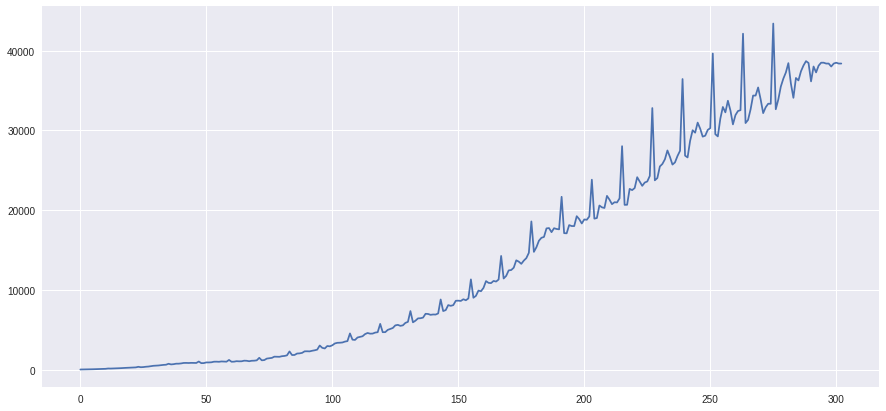

In [101]:
plt.plot(list_value)

In [0]:
res = []
for i in range(3):
    start = i * 68
    end = start + 68
    end_pred = end + 68
    regr.fit(s_fit.loc[start:end, ['salary', 'next1', 'next2', 'next3', 'next4', 'next5', 'next6', 'next7', 'next8', 'next9']], s_fit.loc[start:end, 'next10'])
    list_value = s_fit.loc[start:end, 'salary'].tolist()
    for i in range(0, 68):
        n = regr.predict(np.array(list_value[-11: -1]).reshape([1,10]))
        list_value.append(n)
    res.append(list_value)

In [0]:
score = []
score2 = []
for i in range(3):
    start = i * 68
    end = start + 68
    end_pred = end +68
    r2 = r2_score(s_fit.loc[end:end_pred-1,'next10'], res[i][-69:-1])
    r1 = mean_absolute_error(s_fit.loc[end:end_pred-1,'next10'], res[i][-69:-1])
    score2.append(r2)
    score.append(r1)

In [105]:
score, score2

([2773.483823529412, 7425.060294117647, 8725.514705882355],
 [-2.1827461958060113, -2.8350720034715575, -2.9146703382370722])

In [107]:
np.mean(score), np.mean(score2)

(6308.019607843137, -2.644162845838214)

In [0]:
lst2 = []
lst1 = []
predicts = []
for i in range(3):
    start = i * 71
    end = start + 71
    end_pred = end + 71
    model=fit_model(s.salary_box[0:end])
    pred =  invboxcox(model.predict(start=end, end=end_pred-1), lmbda)
    predicts.append(pred)
    lst2.append(r2_score(s2.salary[end:end_pred],pred))
    lst1.append(mean_absolute_error(s2.salary[end:end_pred],pred))

In [109]:
lst2, lst1

([0.9507214718803447, 0.023966587611527923, 0.2838246334970208],
 [306.7898301328214, 3843.7520670267068, 3847.893634435164])

In [110]:
np.mean(lst1), np.mean(lst2)в



(2666.1451771982306, 0.4195042309962978)

Спасибо большое за подсказку. По-хорошему вы правы, так  как предсказание более менее линейное, то среднее мы всегда предскажем верно, но ошибемся в сезонности, в sarima мы пытаемся угадать сезонность и если это не получается, то мы сильно ошибаемся, если не ошибаемся, то ошибка маленькая